In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [18]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [22]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
last = session.query(Measurement).group_by(Measurement.date).order_by(desc(Measurement.date)).first()
last.date

'2017-08-23'

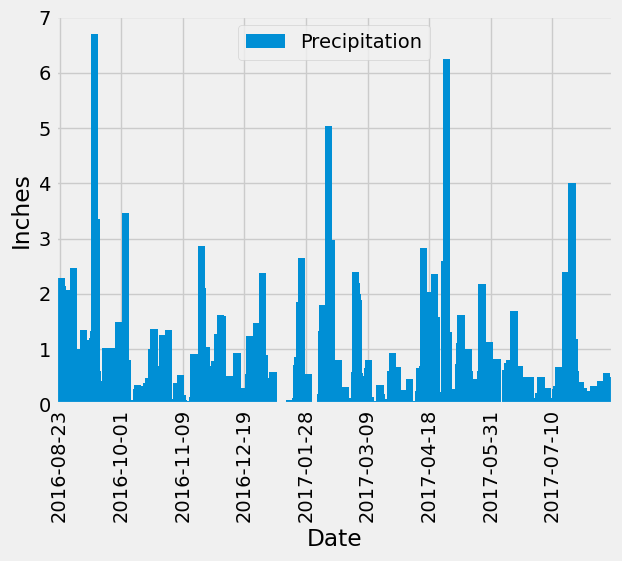

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = last.date

# Calculate the date one year from the last date in data set.
start_date = (dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
year_dates = session.query(Measurement).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
             .with_entities(Measurement.date, Measurement.prcp)


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(year_dates, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df_sorted = df.sort_values(["Date"])

# Use Pandas Plotting with Matplotlib to plot the data
ax = df_sorted.plot.bar(xlabel="Date", ylabel="Inches",grid=True, width=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.show()



In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_sorted.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).group_by(Station.station).count()

print(station_count)

9


In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
row_count = session.query(Measurement.station, func.count(Measurement.tobs).label("temp_count"))\
        .group_by(Measurement.station).order_by(desc("temp_count")).all()


row_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = session.query(func.min(Measurement.tobs).label("tmin"), func.max(Measurement.tobs).label("tmax"), func.avg(Measurement.tobs).label("tavg")).filter(Measurement.station == 'USC00519281').all()

active_station


[(54.0, 85.0, 71.66378066378067)]

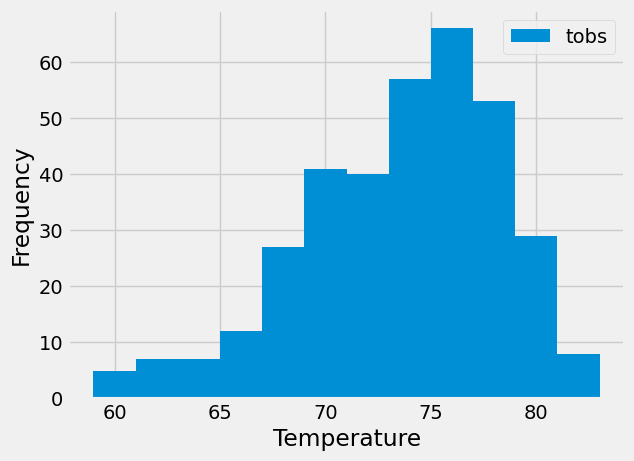

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_dates = session.query(Measurement).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
             .filter(Measurement.station == 'USC00519281').with_entities(Measurement.tobs)

temp_df = pd.read_sql(temp_dates.statement, engine)

fig2 = temp_df.plot.hist(column=['tobs'], bins=12)
fig2.set_xlabel("Temperature")
plt.show()

# Close Session

In [32]:
# Close Session
session.close()